## Import the model

In [ ]:


# Import necessary libraries
import torch
from transformers import AutoTokenizer, AutoModel

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load the model and tokenizer
def load_dnabert():
    try:
        # For transformers version 4.28
        tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
        model = AutoModel.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
    except:
        # For transformers version > 4.28
        from transformers.models.bert.configuration_bert import BertConfig
        config = BertConfig.from_pretrained("zhihan1996/DNABERT-2-117M")
        tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True)
        model = AutoModel.from_pretrained("zhihan1996/DNABERT-2-117M", trust_remote_code=True, config=config)
    
    model = model.to(device)
    return tokenizer, model

tokenizer, model = load_dnabert()

# Function to get embeddings for a DNA sequence
def get_dna_embeddings(sequence, model, tokenizer):
    # Tokenize the sequence
    inputs = tokenizer(sequence, return_tensors='pt')
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Get model outputs
    with torch.no_grad():
        outputs = model(inputs['input_ids'])
    hidden_states = outputs[0]
    
    # Calculate embeddings using both pooling methods
    embedding_mean = torch.mean(hidden_states[0], dim=0)
    embedding_max = torch.max(hidden_states[0], dim=0)[0]
    
    return embedding_mean, embedding_max

# Test the model with an example sequence
example_dna = "ACGTAGCATCGGATCTATCTATCGACACTTGGTTATCGATCTACGAGCATCTCGTTAGC"
emb_mean, emb_max = get_dna_embeddings(example_dna, model, tokenizer)

print("Mean pooling embedding shape:", emb_mean.shape)
print("Max pooling embedding shape:", emb_max.shape)

# Example of how to use the embeddings for multiple sequences
def process_multiple_sequences(sequences):
    results = []
    for seq in sequences:
        emb_mean, emb_max = get_dna_embeddings(seq, model, tokenizer)
        results.append({
            'sequence': seq,
            'mean_embedding': emb_mean.cpu().numpy(),
            'max_embedding': emb_max.cpu().numpy()
        })
    return results

# Test with multiple sequences
test_sequences = [
    "ACGTAGCATCGGAT",
    "TCTATCTATCGACA",
    "CTTGGTTATCGATC"
]

results = process_multiple_sequences(test_sequences)
print(f"\nProcessed {len(results)} sequences successfully!")

/home/youss/DNA-bert/dna_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


/home/youss/.cache/huggingface/modules/transformers_modules/zhihan1996/DNABERT-2-117M/d064dece8a8b41d9fb8729fbe3435278786931f1/bert_layers.py:126: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of BertModel were not initialized from the model checkpoint at zhihan1996/DNABERT-2-117M and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Mean pooling embedding shape: torch.Size([768])
Max pooling embedding shape: torch.Size([768])

Processed 3 sequences successfully!


In [2]:
# %% cell 3 code
import time
import random

# Generate a large random DNA sequence (1000 bases)
bases = ['A', 'C', 'G', 'T']
large_dna_sequence = "".join(random.choice(bases) for _ in range(1000))
print(f"Generated a DNA sequence of length: {len(large_dna_sequence)}")

# Measure inference time
start_time = time.time()
emb_mean_large, emb_max_large = get_dna_embeddings(large_dna_sequence, model, tokenizer)
end_time = time.time()

duration = end_time - start_time

print(f"\nInference for {len(large_dna_sequence)} bases took: {duration:.4f} seconds")
print("Mean pooling embedding shape:", emb_mean_large.shape)
print("Max pooling embedding shape:", emb_max_large.shape)


Generated a DNA sequence of length: 1000

Inference for 1000 bases took: 0.1079 seconds
Mean pooling embedding shape: torch.Size([768])
Max pooling embedding shape: torch.Size([768])


In [4]:
import pandas as pd

# Load the dataset
file_path = '/home/youss/DNA-bert/SLC19A3_MUTATIONS_10K_Context.csv'
df = pd.read_csv(file_path)

# Print the head of the dataframe
print("DataFrame Head:")
print(df.head())


DataFrame Head:
   #chr        pos variation variant_type   snp_id clinical_significance  \
0     2  227685293       A>G          snv  1055957                normal   
1     2  227685293       A>G          snv  1055957                benign   
2     2  227685434       G>A          snv  1134281                normal   
3     2  227685434       G>A          snv  1134281                benign   
4     2  227685423       C>A          snv  1134282                normal   

                 validation_status       function_class     gene  \
0  by-frequency;by-alfa;by-cluster  3_prime_UTR_variant  SLC19A3   
1  by-frequency;by-alfa;by-cluster  3_prime_UTR_variant  SLC19A3   
2  by-frequency;by-alfa;by-cluster  3_prime_UTR_variant  SLC19A3   
3  by-frequency;by-alfa;by-cluster  3_prime_UTR_variant  SLC19A3   
4  by-frequency;by-alfa;by-cluster  3_prime_UTR_variant  SLC19A3   

                                           frequency UnifiedLabel  \
0  G:0.044816:224:1000Genomes|G:0.035339:4954:Gno

In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import torch # Ensure torch is available for tensor operations if needed
from tqdm.auto import tqdm # For progress bar

# --- 1. Generate Embeddings ---
print("Generating embeddings for sequences...")
embeddings_list = []
labels_list = []
sequences_list = [] # Keep track of sequences corresponding to embeddings

# Use mean pooling embeddings for this task
embedding_type = 'mean' # or 'max' or 'concatenate'

# Limit the number of sequences for faster testing/debugging if needed
# df_subset = df.head(100) # Uncomment for testing with a smaller subset
df_subset = df

for index, row in tqdm(df_subset.iterrows(), total=df_subset.shape[0], desc="Processing sequences"):
    sequence = row['sequence']
    label = row['ContinuousLabel']

    # Ensure sequence is a string and not empty
    if not isinstance(sequence, str) or len(sequence) == 0:
        print(f"Skipping row {index}: Invalid sequence '{sequence}'")
        continue

    try:
        # Assuming get_dna_embeddings is defined and returns (emb_mean, emb_max)
        emb_mean, emb_max = get_dna_embeddings(sequence, model, tokenizer)

        if embedding_type == 'mean':
            embedding = emb_mean.cpu().numpy()
        elif embedding_type == 'max':
            embedding = emb_max.cpu().numpy()
        elif embedding_type == 'concatenate':
            embedding = torch.cat((emb_mean, emb_max), dim=0).cpu().numpy()
        else:
             # Default to mean if type is unknown
            embedding = emb_mean.cpu().numpy()

        embeddings_list.append(embedding)
        labels_list.append(label)
        sequences_list.append(sequence) # Store the sequence itself if needed later

    except Exception as e:
        print(f"Error processing sequence at index {index}: {e}")
        # Optionally skip problematic sequences or handle differently
        # For now, we skip them
        continue

# Convert lists to NumPy arrays
X = np.array(embeddings_list)
y = np.array(labels_list)

print(f"\nGenerated {X.shape[0]} embeddings of shape {X.shape[1]}.")
print(f"Corresponding labels shape: {y.shape}")

if X.shape[0] == 0:
    print("No embeddings were generated. Cannot proceed with training.")
else:
    # --- 2. Prepare Data and Biased Sampling Weights ---
    print("\nPreparing data and calculating sample weights...")
    # Define weights: higher weight for negative labels (-1, -2)
    # Adjust the weight_multiplier based on desired bias strength
    weight_multiplier_negative = 10.0
    sample_weights = np.array([weight_multiplier_negative if label < 0 else 1.0 for label in y])

    print(f"Sample weights calculated. Example weights: {sample_weights[:10]}")
    print(f"Number of negative samples: {np.sum(y < 0)}")
    print(f"Number of non-negative samples: {np.sum(y >= 0)}")
    print(f"Total weight for negative samples: {np.sum(sample_weights[y < 0]):.2f}")
    print(f"Total weight for non-negative samples: {np.sum(sample_weights[y >= 0]):.2f}")


    # --- 3. Split Data ---
    # Split data into training and testing sets, including sample weights
    # train_test_split returns splits for each input array.
    # Since we pass X, y, and sample_weights, it returns 6 arrays.
    X_train, X_test, y_train, y_test, train_weights, test_weights = train_test_split(
        X, y, sample_weights, test_size=0.2, random_state=42, stratify=y # Stratify helps maintain class distribution
    )

    print(f"\nData split into training ({X_train.shape[0]} samples) and testing ({X_test.shape[0]} samples).")


    # --- 4. Train RandomForest Classifier ---
    print("\nTraining RandomForest Classifier with sample weights...")
    # Initialize the classifier
    # You might want to tune hyperparameters like n_estimators, max_depth, etc.
    # class_weight='balanced' could be an alternative or complementary approach to sample_weight
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1) # Use all available CPU cores

    # Train the model using the training data and the calculated sample weights for the training set
    rf_classifier.fit(X_train, y_train, sample_weight=train_weights)

    print("Training complete.")


    # --- 5. Evaluate the Classifier ---
    print("\nEvaluating the classifier...")
    # Predict on the test set
    y_pred = rf_classifier.predict(X_test)

    # Calculate accuracy
    # Note: accuracy_score does not directly use sample weights for evaluation by default.
    # If weighted evaluation is needed, consider metrics like weighted F1-score or implement custom weighted accuracy.
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nTest Accuracy: {accuracy:.4f}")

    # Print classification report
    print("\nClassification Report:")
    # Get unique labels present in y_test or y_pred for the report
    unique_labels = np.unique(np.concatenate((y_test, y_pred)))
    # The classification_report can accept sample_weight for weighted metrics
    print(classification_report(y_test, y_pred, labels=unique_labels, sample_weight=test_weights, zero_division=0))

    # Print confusion matrix
    print("\nConfusion Matrix:")
    # The confusion_matrix can also accept sample_weight
    print(confusion_matrix(y_test, y_pred, labels=unique_labels, sample_weight=test_weights))


Generating embeddings for sequences...


Processing sequences: 100%|██████████| 1068/1068 [01:14<00:00, 14.37it/s]



Generated 1068 embeddings of shape 768.
Corresponding labels shape: (1068,)

Preparing data and calculating sample weights...
Sample weights calculated. Example weights: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Number of negative samples: 55
Number of non-negative samples: 1013
Total weight for negative samples: 550.00
Total weight for non-negative samples: 1013.00

Data split into training (854 samples) and testing (214 samples).

Training RandomForest Classifier with sample weights...
Training complete.

Evaluating the classifier...

Test Accuracy: 0.5047

Classification Report:
              precision    recall  f1-score   support

          -2       0.00      0.00      0.00      80.0
          -1       0.00      0.00      0.00      30.0
           0       0.26      0.29      0.27      59.0
           1       0.17      0.05      0.07      22.0
           2       0.68      0.66      0.67      32.0
           3       0.33      0.77      0.47      90.0

    accuracy                           0

In [8]:
# Define the path to the sequence file
file_path = 'wild_type_sequence.txt'

# Read the sequence from the file
try:
    with open(file_path, 'r') as f:
        wild_type_sequence = f.read().strip() # Read the whole file and remove leading/trailing whitespace

    # Print the length of the sequence
    print(f"Length of the wild type sequence: {len(wild_type_sequence)}")
    # Optionally, print the sequence itself if it's not too long
    # print(f"Wild type sequence: {wild_type_sequence}")

except FileNotFoundError:
    print(f"Error: The file {file_path} was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

Length of the wild type sequence: 34266


In [19]:
import pandas as pd

# Read the wild type sequence
# Create a copy of the dataframe to avoid modifying the original
df_wild = df.copy()

# Replace sequences where clinical_significance is 'normal' with wild type sequence
df_wild.loc[df_wild['clinical_significance'] == 'normal', 'sequence'] = wild_type_sequence

# Save the modified dataframe
df_wild.to_csv('df_wild.csv', index=False)

print("Number of sequences replaced:", (df_wild['clinical_significance'] == 'normal').sum())
print("Total rows in dataframe:", len(df_wild))

Number of sequences replaced: 447
Total rows in dataframe: 1068


In [20]:
df_wild.head()

,#chr,pos,variation,variant_type,snp_id,clinical_significance,validation_status,function_class,gene,frequency,UnifiedLabel,sequence,ContinuousLabel
0,2,227685293,A>G,snv,1055957,normal,by-frequency;by-alfa;by-cluster,3_prime_UTR_variant,SLC19A3,G:0.044816:224:1000Genomes|G:0.035339:4954:Gno...,benign,TTGGTATGAGTTTCAGTTGTTTATTTATTTGTTTGATTGTTGGTTT...,3
1,2,227685293,A>G,snv,1055957,benign,by-frequency;by-alfa;by-cluster,3_prime_UTR_variant,SLC19A3,G:0.044816:224:1000Genomes|G:0.035339:4954:Gno...,benign,TGCCACCACACCTGGCTAATTTTTGTATTTTTAGTAGAGATGGGGT...,2
2,2,227685434,G>A,snv,1134281,normal,by-frequency;by-alfa;by-cluster,3_prime_UTR_variant,SLC19A3,A:0.095409:478:1000Genomes|A:0.012714:49:ALSPA...,benign,TTGGTATGAGTTTCAGTTGTTTATTTATTTGTTTGATTGTTGGTTT...,3
3,2,227685434,G>A,snv,1134281,benign,by-frequency;by-alfa;by-cluster,3_prime_UTR_variant,SLC19A3,A:0.095409:478:1000Genomes|A:0.012714:49:ALSPA...,benign,CGCCCAGCCATAGGATTATGTCTCTTTTATGTTTGTTTGTTTTCTT...,2
4,2,227685423,C>A,snv,1134282,normal,by-frequency;by-alfa;by-cluster,3_prime_UTR_variant,SLC19A3,A:0.095409:478:1000Genomes|A:0.012714:49:ALSPA...,benign,TTGGTATGAGTTTCAGTTGTTTATTTATTTGTTTGATTGTTGGTTT...,3


In [50]:
import pandas as pd
import copy

def process_variants(df_wild, wild_type_sequence, gene_start=227683763):
    # Create a new dataframe for the modified sequences
    df_processed = df_wild.copy()
    
    # Process only non-normal variants
    mask = df_processed['clinical_significance'] != 'normal'
    
    for idx, row in df_processed[mask].iterrows():
        try:
            # Calculate local position in the gene
            var_local_pos = row['pos'] - gene_start  # -1 for zero-based indexing
            
            # Check if the position is within the bounds of the sequence
            if var_local_pos < 0 or var_local_pos >= len(wild_type_sequence):
                print(f"Warning: Position {var_local_pos} is out of range for sequence of length {len(wild_type_sequence)}. Skipping variant at position {row['pos']}.")
                continue
            
            if row['variant_type'].lower() == 'snv':
                # Handle SNV (Single Nucleotide Variant)
                ref, alts = row['variation'].split('>')
                alts = alts.split(',')  # Split multiple alternative alleles
                
                # Verify reference base
                if wild_type_sequence[var_local_pos] == ref:
                    # Create a row for each alternative allele
                    for alt in alts:
                        if alt != '-':  # Skip if it's a deletion marker
                            new_seq = list(wild_type_sequence)
                            new_seq[var_local_pos] = alt
                            df_processed.at[idx, 'sequence'] = ''.join(new_seq)
                            # If there are multiple alternatives, we need to duplicate the row
                            if len(alts) > 1 and alt != alts[0]:
                                new_row = df_processed.loc[idx].copy()
                                new_row['sequence'] = ''.join(new_seq)
                                df_processed = pd.concat([df_processed, pd.DataFrame([new_row])], ignore_index=True)
                else:
                    print(f"Warning: Reference base mismatch at position {var_local_pos}. Expected {ref}, found {wild_type_sequence[var_local_pos]}")
            
            elif row['variant_type'].lower() == 'delins':
                # Handle deletion-insertion variants
                if '>' in row['variation']:
                    ref, alt = row['variation'].split('>')
                    new_seq = list(wild_type_sequence)
                    
                    if ref == '-':  # Insertion
                        # Insert the new sequence at the position
                        new_seq = new_seq[:var_local_pos] + list(alt) + new_seq[var_local_pos:]
                    elif alt == '-':  # Deletion
                        # Remove the sequence
                        new_seq = new_seq[:var_local_pos] + new_seq[var_local_pos + len(ref):]
                    else:  # Replacement
                        new_seq = new_seq[:var_local_pos] + list(alt) + new_seq[var_local_pos + len(ref):]
                    
                    df_processed.at[idx, 'sequence'] = ''.join(new_seq)
            
            elif row['variant_type'].lower() == 'mnv':
                # Handle Multiple Nucleotide Variants
                ref, alt = row['variation'].split('>')
                new_seq = list(wild_type_sequence)
                # Replace the sequence at the position
                if var_local_pos + len(ref) <= len(wild_type_sequence):
                    new_seq[var_local_pos:var_local_pos + len(ref)] = list(alt)
                    df_processed.at[idx, 'sequence'] = ''.join(new_seq)
                else:
                    print(f"Warning: MNV at position {var_local_pos} extends beyond sequence length. Skipping.")
        
        except Exception as e:
            print(f"Error processing variant at position {row['pos']}: {e}. Skipping.")
            continue

    return df_processed


# Process the variants
try:
    df_processed = process_variants(df_wild, wild_type_sequence)
    
    # Save the processed dataframe
    df_processed.to_csv('df_processed.csv', index=False)
    
    # Print statistics
    print("Number of variants processed:", len(df_processed) - len(df_wild))
    print("Total rows in processed dataframe:", len(df_processed))
except Exception as e:
    print(f"Error during variant processing: {e}")

Number of variants processed: 284
Total rows in processed dataframe: 1352


Generating embeddings for processed sequences...


Processing sequences for NN:   0%|          | 0/1352 [00:00<?, ?it/s]/home/youss/.cache/huggingface/modules/transformers_modules/zhihan1996/DNABERT-2-117M/d064dece8a8b41d9fb8729fbe3435278786931f1/bert_layers.py:433: UserWarning: Increasing alibi size from 1896 to 6468
  warnings.warn(
Processing sequences for NN:   0%|          | 1/1352 [00:00<18:18,  1.23it/s]/home/youss/.cache/huggingface/modules/transformers_modules/zhihan1996/DNABERT-2-117M/d064dece8a8b41d9fb8729fbe3435278786931f1/bert_layers.py:433: UserWarning: Increasing alibi size from 6468 to 6469
  warnings.warn(
Processing sequences for NN:   2%|▏         | 26/1352 [00:10<10:13,  2.16it/s]/home/youss/.cache/huggingface/modules/transformers_modules/zhihan1996/DNABERT-2-117M/d064dece8a8b41d9fb8729fbe3435278786931f1/bert_layers.py:433: UserWarning: Increasing alibi size from 6469 to 6470
  warnings.warn(
Processing sequences for NN:   5%|▍         | 63/1352 [00:28<09:59,  2.15it/s]/home/youss/.cache/huggingface/modules/transfor


Generated 1352 embeddings of shape 768.
Corresponding labels shape: (1352,)

Preparing data for PyTorch...
Original labels: [-2 -1  0  1  2  3]
Encoded labels: [0 1 2 3 4 5]
Number of classes: 6
Label mapping: {np.int64(-2): np.int64(0), np.int64(-1): np.int64(1), np.int64(0): np.int64(2), np.int64(1): np.int64(3), np.int64(2): np.int64(4), np.int64(3): np.int64(5)}
Data split into training (1081 samples) and testing (271 samples).

Defining the Neural Network...
SimpleNN(
  (fc1): Linear(in_features=768, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)
Using device: cuda

Training the Neural Network...


Epoch 1/20 - Loss: 1.5649, Accuracy: 0.3219


Epoch 2/20 - Loss: 1.4784, Accuracy: 0.3182


Epoch 3/20 - Loss: 1.4752, Accuracy: 0.3127


Epoch 4/20 - Loss: 1.4773, Accuracy: 0.3164


Epoch 5/20 - Loss: 1.4753, Accuracy: 0.3256


Epoch 6/20 - Loss: 1.4785, Accuracy: 0.3386


Epoch 7/20 - Loss: 1.4751, Accuracy: 0.3395


Epoch 8/20 - Loss: 1.4778, Accuracy: 0.3191


Epoch 9/20 - Loss: 1.4776, Accuracy: 0.3191


Epoch 10/20 - Loss: 1.4747, Accuracy: 0.3247


Epoch 11/20 - Loss: 1.4778, Accuracy: 0.3275


Epoch 12/20 - Loss: 1.4782, Accuracy: 0.3256


Epoch 13/20 - Loss: 1.4743, Accuracy: 0.3293


Epoch 14/20 - Loss: 1.4777, Accuracy: 0.3414


Epoch 15/20 - Loss: 1.4758, Accuracy: 0.3173


Epoch 16/20 - Loss: 1.4741, Accuracy: 0.3173


Epoch 17/20 - Loss: 1.4757, Accuracy: 0.3164


Epoch 18/20 - Loss: 1.4771, Accuracy: 0.3108


Epoch 19/20 - Loss: 1.4761, Accuracy: 0.3238


Epoch 20/20 - Loss: 1.4801, Accuracy: 0.3330
Training complete.


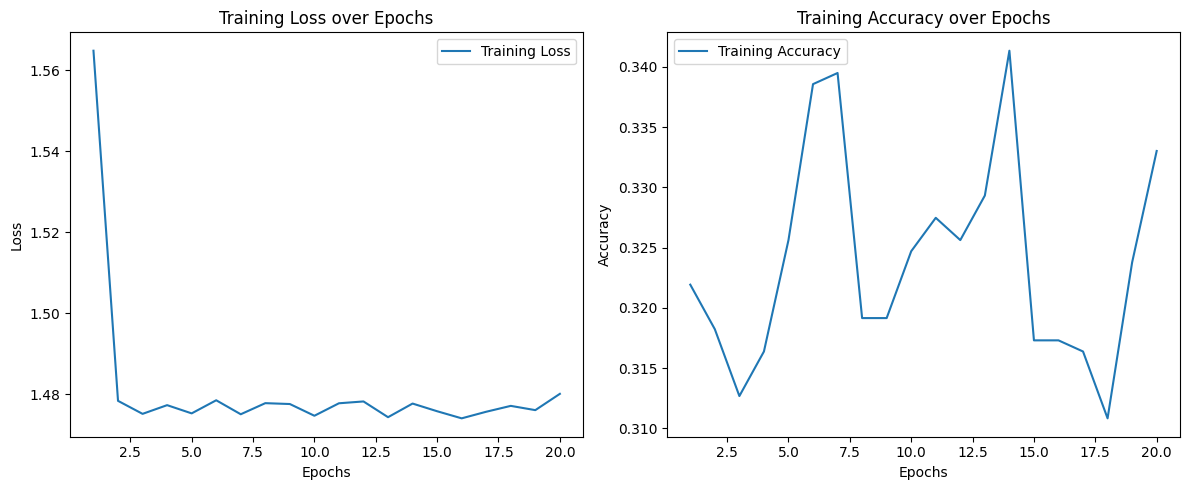


Evaluating the Neural Network...


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 2141.89it/s]



Test Accuracy (NN): 0.3321

Classification Report (NN):
              precision    recall  f1-score   support

          -2       0.00      0.00      0.00        11
          -1       0.00      0.00      0.00         3
           0       0.00      0.00      0.00        90
           1       0.00      0.00      0.00        33
           2       0.00      0.00      0.00        44
           3       0.33      1.00      0.50        90

    accuracy                           0.33       271
   macro avg       0.06      0.17      0.08       271
weighted avg       0.11      0.33      0.17       271


Confusion Matrix (NN):
[[ 0  0  0  0  0 11]
 [ 0  0  0  0  0  3]
 [ 0  0  0  0  0 90]
 [ 0  0  0  0  0 33]
 [ 0  0  1  0  0 43]
 [ 0  0  0  0  0 90]]


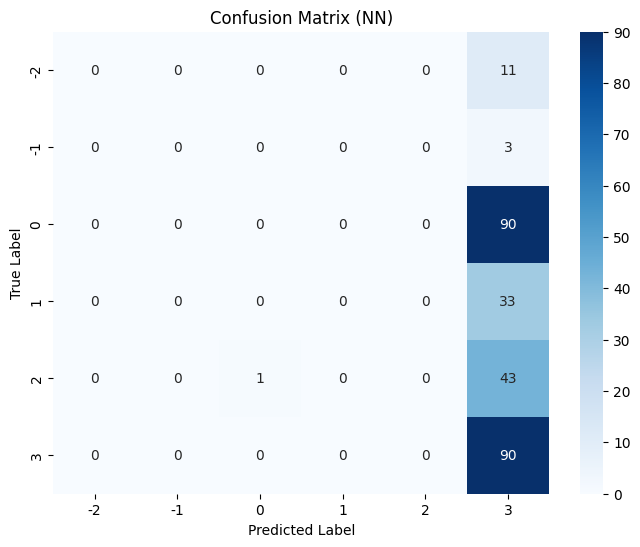

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Ensure df_processed exists from the previous cell
if 'df_processed' not in locals():
    raise NameError("df_processed is not defined. Please run the previous cell to generate it.")

# --- 1. Generate Embeddings using df_processed ---
print("Generating embeddings for processed sequences...")
embeddings_list_nn = []
labels_list_nn = []
sequences_list_nn = [] # Keep track of sequences corresponding to embeddings

# Use mean pooling embeddings for this task
embedding_type_nn = 'mean' # or 'max' or 'concatenate'

# Limit the number of sequences for faster testing/debugging if needed
# df_subset_nn = df_processed.head(200) # Uncomment for testing
df_subset_nn = df_processed

# Assuming get_dna_embeddings, model, and tokenizer are defined from earlier cells
for index, row in tqdm(df_subset_nn.iterrows(), total=df_subset_nn.shape[0], desc="Processing sequences for NN"):
    sequence = row['sequence']
    label = row['ContinuousLabel'] # Assuming this is the correct label column

    # Ensure sequence is a string and not empty
    if not isinstance(sequence, str) or len(sequence) == 0:
        print(f"Skipping row {index}: Invalid sequence '{sequence}'")
        continue

    # Ensure label is valid (e.g., not NaN)
    if pd.isna(label):
        print(f"Skipping row {index}: Invalid label '{label}'")
        continue

    try:
        # Assuming get_dna_embeddings returns (emb_mean, emb_max) as PyTorch tensors
        emb_mean, emb_max = get_dna_embeddings(sequence, model, tokenizer)

        if embedding_type_nn == 'mean':
            embedding = emb_mean.cpu().numpy().flatten() # Flatten in case it's not already 1D
        elif embedding_type_nn == 'max':
            embedding = emb_max.cpu().numpy().flatten()
        elif embedding_type_nn == 'concatenate':
            embedding = torch.cat((emb_mean, emb_max), dim=1).cpu().numpy().flatten() # Concatenate along feature dim
        else:
             # Default to mean if type is unknown
            embedding = emb_mean.cpu().numpy().flatten()

        embeddings_list_nn.append(embedding)
        labels_list_nn.append(label)
        sequences_list_nn.append(sequence) # Store the sequence itself if needed later

    except Exception as e:
        print(f"Error processing sequence at index {index} ('{sequence[:30]}...'): {e}")
        # Optionally skip problematic sequences or handle differently
        continue

# Convert lists to NumPy arrays
X_nn = np.array(embeddings_list_nn)
y_nn_original = np.array(labels_list_nn)

print(f"\nGenerated {X_nn.shape[0]} embeddings of shape {X_nn.shape[1]}.")
print(f"Corresponding labels shape: {y_nn_original.shape}")

if X_nn.shape[0] == 0:
    print("No embeddings were generated. Cannot proceed with NN training.")
else:
    # --- 2. Prepare Data for PyTorch ---
    print("\nPreparing data for PyTorch...")

    # Encode labels to be zero-indexed integers (required for CrossEntropyLoss)
    le = LabelEncoder()
    y_nn_encoded = le.fit_transform(y_nn_original)
    num_classes = len(le.classes_)
    print(f"Original labels: {np.unique(y_nn_original)}")
    print(f"Encoded labels: {np.unique(y_nn_encoded)}")
    print(f"Number of classes: {num_classes}")
    print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))


    # Split data into training and testing sets
    X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(
        X_nn, y_nn_encoded, test_size=0.2, random_state=42, stratify=y_nn_encoded # Stratify helps maintain class distribution
    )

    print(f"Data split into training ({X_train_nn.shape[0]} samples) and testing ({X_test_nn.shape[0]} samples).")

    # Convert NumPy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_nn, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_nn, dtype=torch.long) # Use long for CrossEntropyLoss
    X_test_tensor = torch.tensor(X_test_nn, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_nn, dtype=torch.long)

    # Create TensorDatasets and DataLoaders
    batch_size = 32
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


    # --- 3. Define the Neural Network ---
    print("\nDefining the Neural Network...")
    input_dim = X_train_nn.shape[1]
    hidden_dim = 128 # Example hidden layer size

    class SimpleNN(nn.Module):
        def __init__(self, input_dim, hidden_dim, output_dim):
            super(SimpleNN, self).__init__()
            self.fc1 = nn.Linear(input_dim, hidden_dim)
            self.relu = nn.ReLU()
            self.fc2 = nn.Linear(hidden_dim, output_dim)
            # No softmax here, as CrossEntropyLoss includes it

        def forward(self, x):
            out = self.fc1(x)
            out = self.relu(out)
            out = self.fc2(out)
            return out

    nn_model = SimpleNN(input_dim, hidden_dim, num_classes)
    print(nn_model)

    # Check for GPU availability
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    nn_model.to(device)
    print(f"Using device: {device}")


    # --- 4. Define Loss Function and Optimizer ---
    # Consider using class weights if dataset is imbalanced
    # Example: calculate weights based on class frequency
    # class_counts = np.bincount(y_train_nn)
    # class_weights = 1. / torch.tensor(class_counts, dtype=torch.float32)
    # class_weights = class_weights / class_weights.sum() * num_classes # Normalize
    # criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    criterion = nn.CrossEntropyLoss() # Standard Cross Entropy Loss
    optimizer = optim.Adam(nn_model.parameters(), lr=0.001)


    # --- 5. Train the Neural Network ---
    print("\nTraining the Neural Network...")
    num_epochs = 20 # Adjust as needed
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        nn_model.train() # Set model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = nn_model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            progress_bar.set_postfix({'loss': loss.item()})


        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_train / total_train
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")


    print("Training complete.")

    # Plot training loss and accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy over Epochs')
    plt.legend()
    plt.tight_layout()
    plt.show()


    # --- 6. Evaluate the Neural Network ---
    print("\nEvaluating the Neural Network...")
    nn_model.eval() # Set model to evaluation mode
    y_pred_list = []
    y_true_list = []

    with torch.no_grad(): # Disable gradient calculations
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = nn_model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            y_pred_list.extend(predicted.cpu().numpy())
            y_true_list.extend(labels.cpu().numpy())

    # Convert predictions and true labels back to original labels if needed for interpretation
    y_pred_nn = np.array(y_pred_list)
    y_test_nn_eval = np.array(y_true_list) # These are already the encoded labels (0, 1, 2...)

    # Calculate accuracy
    accuracy_nn = accuracy_score(y_test_nn_eval, y_pred_nn)
    print(f"\nTest Accuracy (NN): {accuracy_nn:.4f}")

    # Print classification report
    print("\nClassification Report (NN):")
    # Use encoded labels for report, but provide target names using the label encoder
    print(classification_report(y_test_nn_eval, y_pred_nn, target_names=[str(cls) for cls in le.classes_], zero_division=0))

    # Print confusion matrix
    print("\nConfusion Matrix (NN):")
    # Use encoded labels for matrix, display with original class names as ticks if desired
    cm = confusion_matrix(y_test_nn_eval, y_pred_nn, labels=le.transform(le.classes_))
    print(cm)

    # Optional: Display confusion matrix with labels
    try:
        import seaborn as sns
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix (NN)')
        plt.show()
    except ImportError:
        print("Seaborn not installed. Skipping heatmap visualization.")
        print("Confusion Matrix (row=True, col=Predicted):")
        print(pd.DataFrame(cm, index=le.classes_, columns=le.classes_))


### Evo2

Generating embeddings for processed sequences...


Processing sequences for NN:   0%|          | 0/1352 [00:00<?, ?it/s]/home/youss/.cache/huggingface/modules/transformers_modules/zhihan1996/DNABERT-2-117M/d064dece8a8b41d9fb8729fbe3435278786931f1/bert_layers.py:433: UserWarning: Increasing alibi size from 1896 to 6468
  warnings.warn(
Processing sequences for NN:   0%|          | 1/1352 [00:00<18:18,  1.23it/s]/home/youss/.cache/huggingface/modules/transformers_modules/zhihan1996/DNABERT-2-117M/d064dece8a8b41d9fb8729fbe3435278786931f1/bert_layers.py:433: UserWarning: Increasing alibi size from 6468 to 6469
  warnings.warn(
Processing sequences for NN:   2%|▏         | 26/1352 [00:10<10:13,  2.16it/s]/home/youss/.cache/huggingface/modules/transformers_modules/zhihan1996/DNABERT-2-117M/d064dece8a8b41d9fb8729fbe3435278786931f1/bert_layers.py:433: UserWarning: Increasing alibi size from 6469 to 6470
  warnings.warn(
Processing sequences for NN:   5%|▍         | 63/1352 [00:28<09:59,  2.15it/s]/home/youss/.cache/huggingface/modules/transfor


Generated 1352 embeddings of shape 768.
Corresponding labels shape: (1352,)

Preparing data for PyTorch...
Original labels: [-2 -1  0  1  2  3]
Encoded labels: [0 1 2 3 4 5]
Number of classes: 6
Label mapping: {np.int64(-2): np.int64(0), np.int64(-1): np.int64(1), np.int64(0): np.int64(2), np.int64(1): np.int64(3), np.int64(2): np.int64(4), np.int64(3): np.int64(5)}
Data split into training (1081 samples) and testing (271 samples).

Defining the Neural Network...
SimpleNN(
  (fc1): Linear(in_features=768, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)
Using device: cuda

Training the Neural Network...


Epoch 1/20 - Loss: 1.5649, Accuracy: 0.3219


Epoch 2/20 - Loss: 1.4784, Accuracy: 0.3182


Epoch 3/20 - Loss: 1.4752, Accuracy: 0.3127


Epoch 4/20 - Loss: 1.4773, Accuracy: 0.3164


Epoch 5/20 - Loss: 1.4753, Accuracy: 0.3256


Epoch 6/20 - Loss: 1.4785, Accuracy: 0.3386


Epoch 7/20 - Loss: 1.4751, Accuracy: 0.3395


Epoch 8/20 - Loss: 1.4778, Accuracy: 0.3191


Epoch 9/20 - Loss: 1.4776, Accuracy: 0.3191


Epoch 10/20 - Loss: 1.4747, Accuracy: 0.3247


Epoch 11/20 - Loss: 1.4778, Accuracy: 0.3275


Epoch 12/20 - Loss: 1.4782, Accuracy: 0.3256


Epoch 13/20 - Loss: 1.4743, Accuracy: 0.3293


Epoch 14/20 - Loss: 1.4777, Accuracy: 0.3414


Epoch 15/20 - Loss: 1.4758, Accuracy: 0.3173


Epoch 16/20 - Loss: 1.4741, Accuracy: 0.3173


Epoch 17/20 - Loss: 1.4757, Accuracy: 0.3164


Epoch 18/20 - Loss: 1.4771, Accuracy: 0.3108


Epoch 19/20 - Loss: 1.4761, Accuracy: 0.3238


Epoch 20/20 - Loss: 1.4801, Accuracy: 0.3330
Training complete.


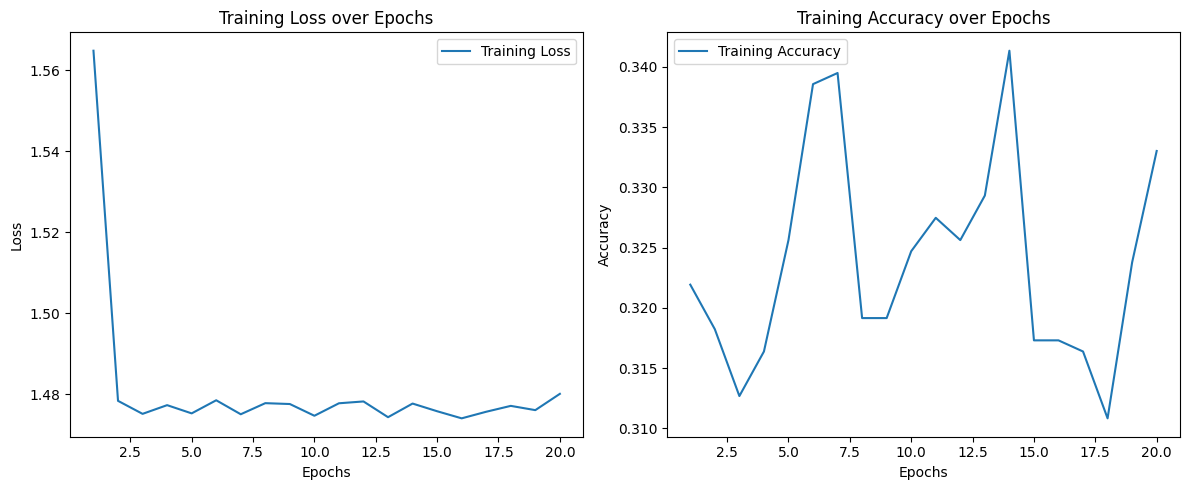


Evaluating the Neural Network...


Evaluating: 100%|██████████| 9/9 [00:00<00:00, 2141.89it/s]



Test Accuracy (NN): 0.3321

Classification Report (NN):
              precision    recall  f1-score   support

          -2       0.00      0.00      0.00        11
          -1       0.00      0.00      0.00         3
           0       0.00      0.00      0.00        90
           1       0.00      0.00      0.00        33
           2       0.00      0.00      0.00        44
           3       0.33      1.00      0.50        90

    accuracy                           0.33       271
   macro avg       0.06      0.17      0.08       271
weighted avg       0.11      0.33      0.17       271


Confusion Matrix (NN):
[[ 0  0  0  0  0 11]
 [ 0  0  0  0  0  3]
 [ 0  0  0  0  0 90]
 [ 0  0  0  0  0 33]
 [ 0  0  1  0  0 43]
 [ 0  0  0  0  0 90]]


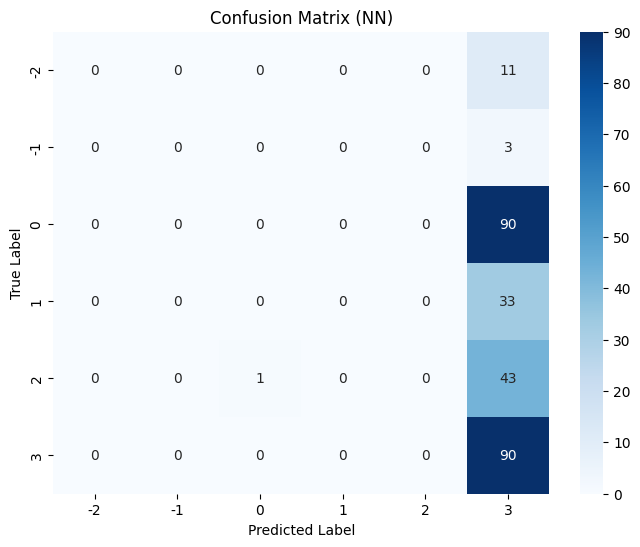

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Ensure df_processed exists from the previous cell
if 'df_processed' not in locals():
    raise NameError("df_processed is not defined. Please run the previous cell to generate it.")

# --- 1. Generate Embeddings using df_processed ---
print("Generating embeddings for processed sequences...")
embeddings_list_nn = []
labels_list_nn = []
sequences_list_nn = [] # Keep track of sequences corresponding to embeddings

# Use mean pooling embeddings for this task
embedding_type_nn = 'mean' # or 'max' or 'concatenate'

# Limit the number of sequences for faster testing/debugging if needed
# df_subset_nn = df_processed.head(200) # Uncomment for testing
df_subset_nn = df_processed

# Assuming get_dna_embeddings, model, and tokenizer are defined from earlier cells
for index, row in tqdm(df_subset_nn.iterrows(), total=df_subset_nn.shape[0], desc="Processing sequences for NN"):
    sequence = row['sequence']
    label = row['ContinuousLabel'] # Assuming this is the correct label column

    # Ensure sequence is a string and not empty
    if not isinstance(sequence, str) or len(sequence) == 0:
        print(f"Skipping row {index}: Invalid sequence '{sequence}'")
        continue

    # Ensure label is valid (e.g., not NaN)
    if pd.isna(label):
        print(f"Skipping row {index}: Invalid label '{label}'")
        continue

    try:
        # Assuming get_dna_embeddings returns (emb_mean, emb_max) as PyTorch tensors
        emb_mean, emb_max = get_dna_embeddings(sequence, model, tokenizer)

        if embedding_type_nn == 'mean':
            embedding = emb_mean.cpu().numpy().flatten() # Flatten in case it's not already 1D
        elif embedding_type_nn == 'max':
            embedding = emb_max.cpu().numpy().flatten()
        elif embedding_type_nn == 'concatenate':
            embedding = torch.cat((emb_mean, emb_max), dim=1).cpu().numpy().flatten() # Concatenate along feature dim
        else:
             # Default to mean if type is unknown
            embedding = emb_mean.cpu().numpy().flatten()

        embeddings_list_nn.append(embedding)
        labels_list_nn.append(label)
        sequences_list_nn.append(sequence) # Store the sequence itself if needed later

    except Exception as e:
        print(f"Error processing sequence at index {index} ('{sequence[:30]}...'): {e}")
        # Optionally skip problematic sequences or handle differently
        continue

# Convert lists to NumPy arrays
X_nn = np.array(embeddings_list_nn)
y_nn_original = np.array(labels_list_nn)

print(f"\nGenerated {X_nn.shape[0]} embeddings of shape {X_nn.shape[1]}.")
print(f"Corresponding labels shape: {y_nn_original.shape}")

if X_nn.shape[0] == 0:
    print("No embeddings were generated. Cannot proceed with NN training.")
else:
    # --- 2. Prepare Data for PyTorch ---
    print("\nPreparing data for PyTorch...")

    # Encode labels to be zero-indexed integers (required for CrossEntropyLoss)
    le = LabelEncoder()
    y_nn_encoded = le.fit_transform(y_nn_original)
    num_classes = len(le.classes_)
    print(f"Original labels: {np.unique(y_nn_original)}")
    print(f"Encoded labels: {np.unique(y_nn_encoded)}")
    print(f"Number of classes: {num_classes}")
    print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))


    # Split data into training and testing sets
    X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(
        X_nn, y_nn_encoded, test_size=0.2, random_state=42, stratify=y_nn_encoded # Stratify helps maintain class distribution
    )

    print(f"Data split into training ({X_train_nn.shape[0]} samples) and testing ({X_test_nn.shape[0]} samples).")

    # Convert NumPy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_nn, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_nn, dtype=torch.long) # Use long for CrossEntropyLoss
    X_test_tensor = torch.tensor(X_test_nn, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_nn, dtype=torch.long)

    # Create TensorDatasets and DataLoaders
    batch_size = 32
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


    # --- 3. Define the Neural Network ---
    print("\nDefining the Neural Network...")
    input_dim = X_train_nn.shape[1]
    hidden_dim = 128 # Example hidden layer size

    class SimpleNN(nn.Module):
        def __init__(self, input_dim, hidden_dim, output_dim):
            super(SimpleNN, self).__init__()
            self.fc1 = nn.Linear(input_dim, hidden_dim)
            self.relu = nn.ReLU()
            self.fc2 = nn.Linear(hidden_dim, output_dim)
            # No softmax here, as CrossEntropyLoss includes it

        def forward(self, x):
            out = self.fc1(x)
            out = self.relu(out)
            out = self.fc2(out)
            return out

    nn_model = SimpleNN(input_dim, hidden_dim, num_classes)
    print(nn_model)

    # Check for GPU availability
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    nn_model.to(device)
    print(f"Using device: {device}")


    # --- 4. Define Loss Function and Optimizer ---
    # Consider using class weights if dataset is imbalanced
    # Example: calculate weights based on class frequency
    # class_counts = np.bincount(y_train_nn)
    # class_weights = 1. / torch.tensor(class_counts, dtype=torch.float32)
    # class_weights = class_weights / class_weights.sum() * num_classes # Normalize
    # criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    criterion = nn.CrossEntropyLoss() # Standard Cross Entropy Loss
    optimizer = optim.Adam(nn_model.parameters(), lr=0.001)


    # --- 5. Train the Neural Network ---
    print("\nTraining the Neural Network...")
    num_epochs = 20 # Adjust as needed
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        nn_model.train() # Set model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = nn_model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            progress_bar.set_postfix({'loss': loss.item()})


        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_train / total_train
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")


    print("Training complete.")

    # Plot training loss and accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy over Epochs')
    plt.legend()
    plt.tight_layout()
    plt.show()


    # --- 6. Evaluate the Neural Network ---
    print("\nEvaluating the Neural Network...")
    nn_model.eval() # Set model to evaluation mode
    y_pred_list = []
    y_true_list = []

    with torch.no_grad(): # Disable gradient calculations
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = nn_model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            y_pred_list.extend(predicted.cpu().numpy())
            y_true_list.extend(labels.cpu().numpy())

    # Convert predictions and true labels back to original labels if needed for interpretation
    y_pred_nn = np.array(y_pred_list)
    y_test_nn_eval = np.array(y_true_list) # These are already the encoded labels (0, 1, 2...)

    # Calculate accuracy
    accuracy_nn = accuracy_score(y_test_nn_eval, y_pred_nn)
    print(f"\nTest Accuracy (NN): {accuracy_nn:.4f}")

    # Print classification report
    print("\nClassification Report (NN):")
    # Use encoded labels for report, but provide target names using the label encoder
    print(classification_report(y_test_nn_eval, y_pred_nn, target_names=[str(cls) for cls in le.classes_], zero_division=0))

    # Print confusion matrix
    print("\nConfusion Matrix (NN):")
    # Use encoded labels for matrix, display with original class names as ticks if desired
    cm = confusion_matrix(y_test_nn_eval, y_pred_nn, labels=le.transform(le.classes_))
    print(cm)

    # Optional: Display confusion matrix with labels
    try:
        import seaborn as sns
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix (NN)')
        plt.show()
    except ImportError:
        print("Seaborn not installed. Skipping heatmap visualization.")
        print("Confusion Matrix (row=True, col=Predicted):")
        print(pd.DataFrame(cm, index=le.classes_, columns=le.classes_))


In [11]:
# Previous imports...
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd # Make sure pandas is imported

# --- NEW: Import Evo 2 ---
from evo2 import Evo2

# Ensure df_processed exists from the previous cell

# --- NEW: Load Evo 2 Model (outside loop) ---
print("Loading Evo 2 model (evo2_7b)...")
try:
    evo2_model = evo2('evo2_7b')
    # Move model to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # evo2_model.to(device) # Evo2's internal structure might handle device placement
    print(f"Evo 2 model loaded. Using device: {device}") # Note: Evo2 might manage its own device placement. Check its behavior.
except Exception as e:
    print(f"Error loading Evo 2 model: {e}")
    raise

# --- Modified Embedding Generation ---
print("Generating embeddings using Evo 2...")
embeddings_list_nn = []
labels_list_nn = []
sequences_list_nn = [] # Keep track of sequences corresponding to embeddings

# Use mean pooling embeddings for this task
embedding_type_nn = 'mean' # or 'max' or 'concatenate'

# Limit the number of sequences for faster testing/debugging if needed
# df_subset_nn = df_processed.head(50) # Uncomment for testing
df_subset_nn = df_processed

# --- NEW: Evo 2 Embedding Loop ---
for index, row in tqdm(df_subset_nn.iterrows(), total=df_subset_nn.shape[0], desc="Processing sequences with Evo 2"):
    sequence = row['sequence']
    label = row['ContinuousLabel'] # Assuming this is the correct label column

    # Ensure sequence is a string and not empty
    if not isinstance(sequence, str) or len(sequence) == 0:
        print(f"Skipping row {index}: Invalid sequence '{sequence}'")
        continue

    # Ensure label is valid (e.g., not NaN)
    if pd.isna(label):
        print(f"Skipping row {index}: Invalid label '{label}'")
        continue

    try:
        # 1. Tokenize using Evo 2's tokenizer
        # Ensure input is compatible with the expected device
        input_ids = torch.tensor(
            evo2_model.tokenizer.tokenize(sequence),
            dtype=torch.int,
        ).unsqueeze(0).to(device) # Move input tensor to the correct device

        # 2. Get Evo 2 embeddings (e.g., from the final layer)
        # We might need to specify layer_names=['final_layer'] or similar if default doesn't work
        with torch.no_grad():
             # Request final layer embeddings (adjust layer name if needed based on Evo2 structure)
            # Alternatively, just get outputs and use those if embeddings aren't directly available this way.
            # outputs, embeddings_dict = evo2_model(input_ids, return_embeddings=True, layer_names=['final_norm']) # Example using final_norm
            outputs, _ = evo2_model(input_ids) # Get logits/hidden states
            hidden_states = outputs[0] # Assuming this structure [batch, seq_len, hidden_dim]

        # Check sequence length after tokenization (important due to potential truncation)
        actual_seq_len = hidden_states.shape[1]
        if actual_seq_len < len(sequence) * 0.8: # Heuristic check for significant truncation
             print(f"Warning: Sequence at index {index} potentially truncated. Original length ~{len(sequence)}, Processed length: {actual_seq_len}")


        # 3. Pool the embeddings
        # hidden_states shape is likely [1, sequence_length, hidden_size]
        if embedding_type_nn == 'mean':
             # Mean pool over sequence length dimension (dim=1)
            embedding_tensor = torch.mean(hidden_states[0], dim=0)
        elif embedding_type_nn == 'max':
            embedding_tensor = torch.max(hidden_states[0], dim=0)[0]
        else: # Default to mean
            embedding_tensor = torch.mean(hidden_states[0], dim=0)

        embedding = embedding_tensor.cpu().numpy().flatten() # Move to CPU and flatten

        embeddings_list_nn.append(embedding)
        labels_list_nn.append(label)
        sequences_list_nn.append(sequence) # Store the sequence itself if needed later

    except Exception as e:
        print(f"Error processing sequence at index {index} ('{sequence[:30]}...'): {e}")
        # Check for common errors like Out of Memory (OOM)
        if "out of memory" in str(e).lower():
             print("CUDA Out of Memory error encountered. Sequence likely too long for GPU VRAM.")
             print("Consider using smaller batches, shorter sequences, or a machine with more VRAM.")
             # Optionally break or implement a strategy to handle OOM
             # break # Stop processing if OOM occurs
        # Optionally skip problematic sequences or handle differently
        continue

# --- Rest of your code (Prepare data for PyTorch, Define NN, Train, Evaluate) ---
# Make sure the subsequent code uses X_nn and y_nn_original generated here

# Convert lists to NumPy arrays
X_nn = np.array(embeddings_list_nn)
y_nn_original = np.array(labels_list_nn)

# Add a check if embeddings were generated
if X_nn.shape[0] > 0:
    print(f"\nGenerated {X_nn.shape[0]} embeddings using Evo 2, shape {X_nn.shape}.")
    print(f"Corresponding labels shape: {y_nn_original.shape}")

    # --- 2. Prepare Data for PyTorch ---
    # (Your existing code for LabelEncoding, train/test split, Tensors, DataLoaders)
    # ... (rest of the code remains the same) ...

else:
    print("No embeddings were generated with Evo 2. Cannot proceed.")

# (Your existing code for NN definition, training, evaluation)
# ...

ImportError: cannot import name 'Evo2' from 'evo2' (unknown location)